# 3 - Resolvendo problemas na rede neural

Nosso objetivo é usar redes neurais para gerar algo que se parece com português. Mais especificamente, algo que se pareça com um português específico --- aquele usado por Machado de Assis.

O código desse notebook é adaptado do repositório `nn-zero-to-hero`, de Andrej Karpathy. Os notebooks correspondentes (em inglês) podem ser encontradas na seguinte URL: https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/.

-------------------------------

Uma direção natural para melhorar nossa rede é adicionar mais camadas. Mas se começássemos a complicar o problema, seria difícil saber quais problemas existem no nosso modelo e que estão atrapalhando sua performance. Ao invés disso, vamos olhar com mais cuidado para alguns problemas que já estão patentes com uma camada.

Vamos começar recuperando os resultados que obtivemos até aqui.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

with open("../data/gpt/processed/machado-all.txt", "r") as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: entra string, saem inteiros
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: entram inteiros, sai uma string

data = text

block_size = 3

def build_dataset(data):  
    X, Y = [], []
    context = [0] * block_size
    for ch in data:
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

n1 = int(0.8*len(data))
n2 = int(0.9*len(data))

Xtr, Ytr = build_dataset(data[:n1])
Xdev, Ydev = build_dataset(data[n1:n2])
Xte, Yte = build_dataset(data[n2:])

In [2]:
vocab_size = len(itos)  # número de caracteres: 27 (a, b, c..., z, .)
n_embd = 10  # dimensionalidade do vetor de embedding
n_hidden = 100  # número de neurônios na camada escondida

torch.manual_seed(0)
g = torch.Generator().manual_seed(0)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True
    
stepi = []
lossi = []

max_steps = 100000
batch_size = 32

for i in range(max_steps):
  
    # minibatch: 32 números aleatórios entre 0 e n_tr = 182625
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # embed os caracateres num vetor (batch_size, block_size, n_embd) = (32, 3, 10)
    embcat = emb.view(-1, n_embd * block_size)  # concatenação das últimas duas dimensões
    hpreact = embcat @ W1 + b1  # transformação afim
    h = torch.tanh(hpreact) # camada escondida: (32, 200)
    logits = h @ W2 + b2 # output: (32, 27)
    loss = F.cross_entropy(logits, Yb)  # função-perda

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    #lr = lrs[i]
    lr = 0.1 if i < 80000 else 0.01  # decaimento da learning rate
    for p in parameters:
        p.data += -lr * p.grad

    # stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    stepi.append(i)
    lossi.append(loss.log10().item())

      0/ 100000: 21.1271
  10000/ 100000: 2.0981
  20000/ 100000: 2.1155
  30000/ 100000: 2.3727
  40000/ 100000: 1.8811
  50000/ 100000: 1.6864
  60000/ 100000: 1.9813
  70000/ 100000: 2.1054
  80000/ 100000: 1.6578
  90000/ 100000: 1.6502


## 3.1 Problema: perda inicial

Olhando para o valor da nossa perda ao longo do treino, é fácil ver que ela começa de uma configuração inicial muito ruim. 

In [3]:
for step, loss in list(zip(stepi, lossi))[::10000]:
    print(f"{step}: {10**loss}")

0: 21.12712039721143
10000: 2.098104924138757
20000: 2.115535077020944
30000: 2.37270911283154
40000: 1.8810682603985047
50000: 1.68644822293465
60000: 1.9813057620693728
70000: 2.105358900430593
80000: 1.6577753017597554
90000: 1.6502416193680276


Sabemos que essa perda inicial é muito ruim não só porque logo em seguida ela fica melhor, mas porque já vimos que, se fizéssemos uma previsão uniforme de qual é o caractere seguinte, teríamos uma perda de:

In [4]:
-torch.tensor(1/len(itos)).log()

tensor(3.7377)

A nossa perda é muito maior porque, quando inicializamos o modelo ele acaba aleatoriamente dando muito mais peso para algumas sequências de caracteres espúrias. Exemplo:

In [5]:
g = torch.Generator().manual_seed(0)
logits = torch.randn(44, generator = g) * 10  # 26 letras + espaço
probs = torch.softmax(logits, dim=0)
loss = - probs[7].log() # a rede julga altamente improvável sortear h, e se h aparece a perda é enorme
logits, probs, loss

(tensor([-11.2584, -11.5236,  -2.5058,  -4.3388,   8.4871,   6.9201,  -3.1601,
         -21.1522,   3.2227, -12.6333,   3.4998,   3.0813,   1.1984,  12.3766,
          11.1678,  -2.4728, -13.5265, -16.9593,   5.6665,   7.9351,   5.9884,
         -15.5510,  -3.4136,  18.5301,   7.5019,  -5.8550,  -1.7340,   1.8348,
          -1.7396,  -6.7875,   9.3826,   4.8887,  -6.7309,   8.7283,  10.5536,
           1.7784,  -5.1807,  -3.0670, -15.8099,  17.0664,  -4.4622,   7.4402,
          15.2098,  34.1050]),
 tensor([1.9903e-20, 1.5266e-20, 1.2593e-16, 2.0140e-17, 7.4865e-12, 1.5622e-12,
         6.5456e-17, 1.0048e-24, 3.8726e-14, 5.0325e-21, 5.1090e-14, 3.3619e-14,
         5.1149e-15, 3.6598e-10, 1.0926e-10, 1.3016e-16, 2.0600e-21, 6.6533e-23,
         4.4597e-13, 4.3106e-12, 6.1532e-13, 2.7207e-22, 5.0800e-17, 1.7214e-07,
         2.7952e-12, 4.4217e-18, 2.7247e-16, 9.6652e-15, 2.7094e-16, 1.7403e-18,
         1.8331e-11, 2.0489e-13, 1.8415e-18, 9.5287e-12, 5.9120e-11, 9.1357e-15,
         

Note que a multiplicação por 10 acima tem o impacto de deixar a rede muito confiante numa resposta que, a não ser que déssemos muita sorte, está errada. Isso faz com que a perda seja muito grande. Uma saída é inicializar os parâmetros de modo a reduzir os logits da primeira camada, deixando-a um pouco menos confiante. Por exemplo, eis o que acontece se não multiplicarmos os logits por 10:

In [6]:
g = torch.Generator().manual_seed(0)
logits = torch.randn(44, generator = g)  # 26 letras + espaço
probs = torch.softmax(logits, dim=0)
loss = - probs[7].log() # agora h não é mais tão improvável
logits, probs, loss

(tensor([-1.1258, -1.1524, -0.2506, -0.4339,  0.8487,  0.6920, -0.3160, -2.1152,
          0.3223, -1.2633,  0.3500,  0.3081,  0.1198,  1.2377,  1.1168, -0.2473,
         -1.3527, -1.6959,  0.5667,  0.7935,  0.5988, -1.5551, -0.3414,  1.8530,
          0.7502, -0.5855, -0.1734,  0.1835, -0.1740, -0.6787,  0.9383,  0.4889,
         -0.6731,  0.8728,  1.0554,  0.1778, -0.5181, -0.3067, -1.5810,  1.7066,
         -0.4462,  0.7440,  1.5210,  3.4105]),
 tensor([0.0034, 0.0033, 0.0081, 0.0068, 0.0245, 0.0209, 0.0076, 0.0013, 0.0145,
         0.0030, 0.0149, 0.0142, 0.0118, 0.0361, 0.0320, 0.0082, 0.0027, 0.0019,
         0.0185, 0.0232, 0.0191, 0.0022, 0.0074, 0.0668, 0.0222, 0.0058, 0.0088,
         0.0126, 0.0088, 0.0053, 0.0268, 0.0171, 0.0053, 0.0251, 0.0301, 0.0125,
         0.0062, 0.0077, 0.0022, 0.0577, 0.0067, 0.0220, 0.0479, 0.3170]),
 tensor(6.6745))

In [7]:
vocab_size = len(itos)  # número de caracteres: 27 (a, b, c..., z, .)
n_embd = 10  # dimensionalidade do vetor de embedding
n_hidden = 100  # número de neurônios na camada escondida

torch.manual_seed(0)
g = torch.Generator().manual_seed(0)
C = torch.randn((vocab_size, n_embd),                  generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),      generator=g)
b1 = torch.randn(n_hidden,                             generator=g)
# ------------------------------------------------------------------------
W2 = torch.randn((n_hidden, vocab_size),               generator=g) * 0.01
b2 = torch.randn(vocab_size,                           generator=g) * 0
# ------------------------------------------------------------------------
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [8]:
max_steps = 100000
batch_size = 32

for i in range(max_steps):
  
    # minibatch: 32 números aleatórios entre 0 e n_tr = 182625
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # embed os caracateres num vetor (batch_size, block_size, n_embd) = (32, 3, 10)
    embcat = emb.view(-1, n_embd * block_size)  # concatenação das últimas duas dimensões
    hpreact = embcat @ W1 + b1  # transformação afim
    h = torch.tanh(hpreact) # camada escondida: (32, 200)
    logits = h @ W2 + b2 # output: (32, 27)
    loss = F.cross_entropy(logits, Yb)  # função-perda

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    #lr = lrs[i]
    lr = 0.1 if i < 80000 else 0.01  # decaimento da learning rate
    for p in parameters:
        p.data += -lr * p.grad

    # stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    stepi.append(i)
    lossi.append(loss.log10().item())
    
    break

      0/ 100000: 3.7460


Ótimo, já temos uma perda inicial muito melhor. Naturalmente se multiplicássemos `W2` por 0 teríamos exatamente $-\log(1/44)=3.7842$; em geral evitamos fazer isso porque é útil quebrar a simetria entre os pesos das diferentes variáveis. A depender da arquitetura, pode acontecer que, se os pesos das variáveis começam iguais, eles serão iguais sempre.

Agora, vamos treinar as 100000 épocas e ver nosso resultado.

In [9]:
vocab_size = len(itos)  # número de caracteres: 27 (a, b, c..., z, .)
n_embd = 10  # dimensionalidade do vetor de embedding
n_hidden = 100  # número de neurônios na camada escondida

torch.manual_seed(0)
g = torch.Generator().manual_seed(0)
C = torch.randn((vocab_size, n_embd),                  generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),      generator=g)
b1 = torch.randn(n_hidden,                             generator=g)
# ---------------------------------------------------------------------------------------------------------
W2 = torch.randn((n_hidden, vocab_size),               generator=g) * 0.01
b2 = torch.randn(vocab_size,                           generator=g) * 0
# ---------------------------------------------------------------------------------------------------------
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

max_steps = 100000
batch_size = 32

for i in range(max_steps):
  
    # minibatch: 32 números aleatórios entre 0 e n_tr = 182625
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # embed os caracateres num vetor (batch_size, block_size, n_embd) = (32, 3, 10)
    embcat = emb.view(-1, n_embd * block_size)  # concatenação das últimas duas dimensões
    hpreact = embcat @ W1 + b1  # transformação afim
    h = torch.tanh(hpreact) # camada escondida: (32, 200)
    logits = h @ W2 + b2 # output: (32, 27)
    loss = F.cross_entropy(logits, Yb)  # função-perda

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    #lr = lrs[i]
    lr = 0.1 if i < 80000 else 0.01  # decaimento da learning rate
    for p in parameters:
        p.data += -lr * p.grad

    # stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    stepi.append(i)
    lossi.append(loss.log10().item())

      0/ 100000: 3.7460
  10000/ 100000: 2.2105
  20000/ 100000: 1.9254
  30000/ 100000: 2.5038
  40000/ 100000: 1.8675
  50000/ 100000: 1.7017
  60000/ 100000: 2.1290
  70000/ 100000: 2.1391
  80000/ 100000: 1.7443
  90000/ 100000: 1.5623


Vamos checar se a nossa perda de validação melhorou.

In [10]:
@torch.no_grad()
def split_loss(split):
    x, y = {'train': (Xtr, Ytr), 'val': (Xdev, Ydev), 'test': (Xte, Yte)}[split]
    emb = C[x]
    embcat = emb.view(-1, n_embd * block_size)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.8623498678207397
val 1.8296575546264648


Antes estava em 1.88; agora caiu para 1.83. É uma melhora significativa considerando o pouco trabalho que deu.

Moral: uma boa inicialização é importante. Como estamos otimizando uma função não-convexa usando descida de gradiente, o lugar de onde começamos pode importar. No nosso caso, o sorteio de pesos aleatórios é feito de tal maneira que ele inicialmente dá muita confiança ao modelo nas previsões erradas. Uma mudança de inicialização significa que começamos de uma previsão melhor, então o modelo não precisa gastar muitas épocas para aprender a reverter essa inicialização ruim.

## 3.2 Problema: saturação das ativações; gradientes dissipados ou explosivos

Resolvido o problema em `logits`, nós agora vamos olhar para um problema com a ativação tanh. Essa é uma função que pega o tensor `hpreact` e coloca seus valores entre -1 e 1.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/87/Hyperbolic_Tangent.svg/2560px-Hyperbolic_Tangent.svg.png" width="50%" height="50%">

Lembrando que
$$
\tanh'(x)=(1-\tanh(x)^2),
$$
se os valores acabam perto de -1 ou 1, o gradiente é zero e a rede pára de aprender algo nesses neurônios. 

In [11]:
h.shape

torch.Size([32, 100])

In [12]:
h.view(-1).shape

torch.Size([3200])

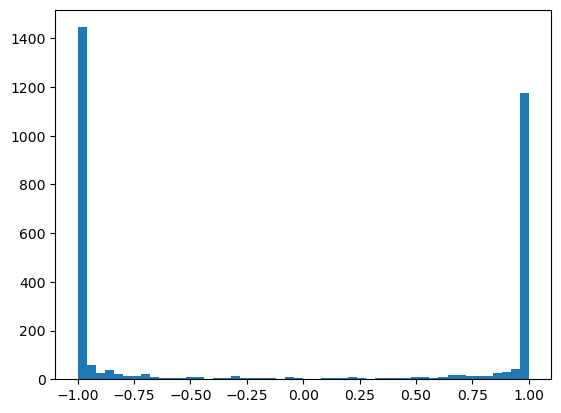

In [13]:
plt.hist(h.view(-1).tolist(), 50);

Uma outra maneira de visualizar o problema é olhando para quais dos 200 neurônios têm valor acima de 0.99 ou abaixo de -0.99 (em branco, abaixo).

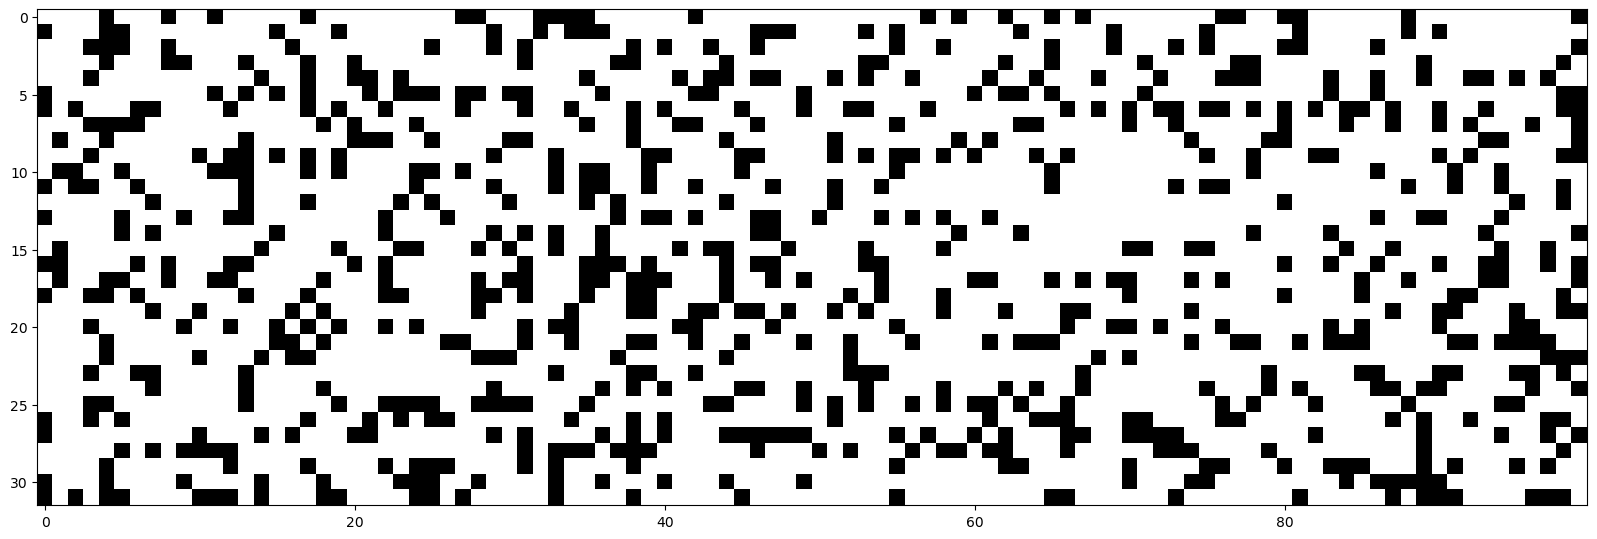

In [14]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

Pelo menos, nenhuma coluna acima (i.e., um neurônio) parece estar com ativação acima de 0.99 ou abaixo de -0.99 para todos os exemplos. Esse seria o caso de um "neurônio morto", ou seja, ele nunca aprenderia nada porque tem gradiente praticamente zero em todos os casos, ou seja, a descida de gradiente manterá esse neurônio do jeito que está. Esse é um risco das funções de ativação que têm grandes regiões planas (e.g., sigmóide, tanh, relu).

Como resolver esse problema? Note que `hpreact = embcat @ W1 + b1`, e `embcat` vem de `C[Xb]`, ou seja, são entradas Normais de média zero e variância um. O problema é que multiplicação por `W1` faz com que a variância de `hpreact` seja muito grande. Solução: inicializar `W1` e `b1` para serem menores.

In [15]:
vocab_size = len(itos)  # número de caracteres: 27 (a, b, c..., z, .)
n_embd = 10  # dimensionalidade do vetor de embedding
n_hidden = 100  # número de neurônios na camada escondida

torch.manual_seed(0)
g = torch.Generator().manual_seed(0)
C = torch.randn((vocab_size, n_embd),                  generator=g)
# ---------------------------------------------------------------------------------------------------------
W1 = torch.randn((n_embd * block_size, n_hidden),      generator=g) * 0.1
b1 = torch.randn(n_hidden,                             generator=g) * 0
W2 = torch.randn((n_hidden, vocab_size),               generator=g) * 0.01
b2 = torch.randn(vocab_size,                           generator=g) * 0
# ---------------------------------------------------------------------------------------------------------
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

max_steps = 100000
batch_size = 32

for i in range(max_steps):
  
    # minibatch: 32 números aleatórios entre 0 e n_tr = 182625
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # embed os caracateres num vetor (batch_size, block_size, n_embd) = (32, 3, 10)
    embcat = emb.view(-1, n_embd * block_size)  # concatenação das últimas duas dimensões
    hpreact = embcat @ W1 + b1  # transformação afim
    h = torch.tanh(hpreact) # camada escondida: (32, 200)
    logits = h @ W2 + b2 # output: (32, 27)
    loss = F.cross_entropy(logits, Yb)  # função-perda

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    #lr = lrs[i]
    lr = 0.1 if i < 80000 else 0.01  # decaimento da learning rate
    for p in parameters:
        p.data += -lr * p.grad

    # stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    stepi.append(i)
    lossi.append(loss.log10().item())
    
    break

      0/ 100000: 3.7402


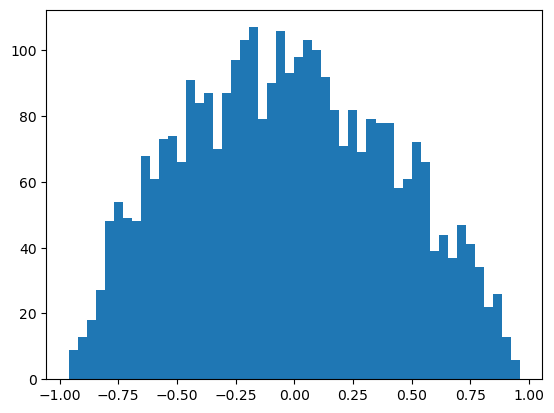

In [16]:
plt.hist(h.view(-1).tolist(), 50);

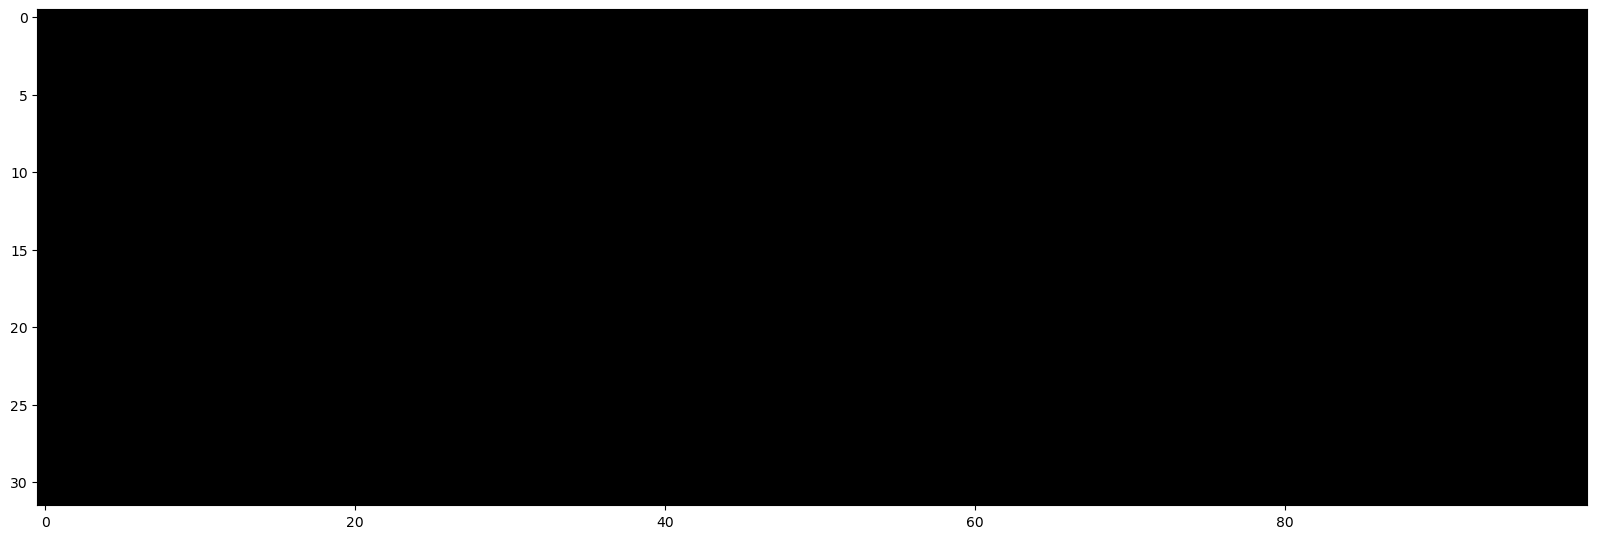

In [17]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

Vamos ver se essa mudança se traduz em alguma melhora para a rede.

In [18]:
vocab_size = len(itos)  # número de caracteres: 27 (a, b, c..., z, .)
n_embd = 10  # dimensionalidade do vetor de embedding
n_hidden = 100  # número de neurônios na camada escondida

torch.manual_seed(0)
g = torch.Generator().manual_seed(0)
C = torch.randn((vocab_size, n_embd),                  generator=g)
# ---------------------------------------------------------------------------------------------------------
W1 = torch.randn((n_embd * block_size, n_hidden),      generator=g) * 0.5  # para não ter todos não-saturados
b1 = torch.randn(n_hidden,                             generator=g) * 0
W2 = torch.randn((n_hidden, vocab_size),               generator=g) * 0.01
b2 = torch.randn(vocab_size,                           generator=g) * 0
# ---------------------------------------------------------------------------------------------------------
parameters = [C, W1, b1, W2, b2]
print(f"Número de parâmetros: {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True

max_steps = 100000
batch_size = 32

for i in range(max_steps):
  
    # minibatch: 32 números aleatórios entre 0 e n_tr = 182625
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # embed os caracateres num vetor (batch_size, block_size, n_embd) = (32, 3, 10)
    embcat = emb.view(-1, n_embd * block_size)  # concatenação das últimas duas dimensões
    hpreact = embcat @ W1 + b1  # transformação afim
    h = torch.tanh(hpreact) # camada escondida: (32, 200)
    logits = h @ W2 + b2 # output: (32, 27)
    loss = F.cross_entropy(logits, Yb)  # função-perda

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    #lr = lrs[i]
    lr = 0.1 if i < 80000 else 0.01  # decaimento da learning rate
    for p in parameters:
        p.data += -lr * p.grad

    # stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    stepi.append(i)
    lossi.append(loss.log10().item())

Número de parâmetros: 7762
      0/ 100000: 3.7415
  10000/ 100000: 2.1436
  20000/ 100000: 1.8962
  30000/ 100000: 2.3563
  40000/ 100000: 1.7643
  50000/ 100000: 1.6293
  60000/ 100000: 1.8460
  70000/ 100000: 2.0908
  80000/ 100000: 1.6093
  90000/ 100000: 1.5143


In [19]:
split_loss('train')
split_loss('val')

train 1.8287471532821655
val 1.7959297895431519


Ok, mais uma melhora! Fomos de 1.83 para 1.80 através de uma escolha mais apropriada de inicialização.

Aqui, o benefício de uma inicialização melhor é limitado. Mas na medida em que formos usar redes mais profundas, uma inicialização precisa é essencial. Se os gradientes ficarem muito pequenos ou grandes rapidamente, a regra da cadeia passa a ter caráter explosivo ou implosivo. 

Nesse sentido, ter uma maneira apropriada de determinar como os parâmetros devem ser inicializados é essencial. 

Existem várias sugestões na literatura sobre como escolher esses valores ao invés de tentativa e erro, como fizemos acima. A lógica é garantir que, apesar das multiplicações dos embeddings pelas transformações lineares, elas nunca ficarão muito grandes ou muito pequenas. Posto de outra maneira, queremos garantir que o desvio-padrão antes e depois das transformações lineares mantem certa regularidade.

tensor(-0.0004) tensor(0.9914)
tensor(0.0070) tensor(3.0883)


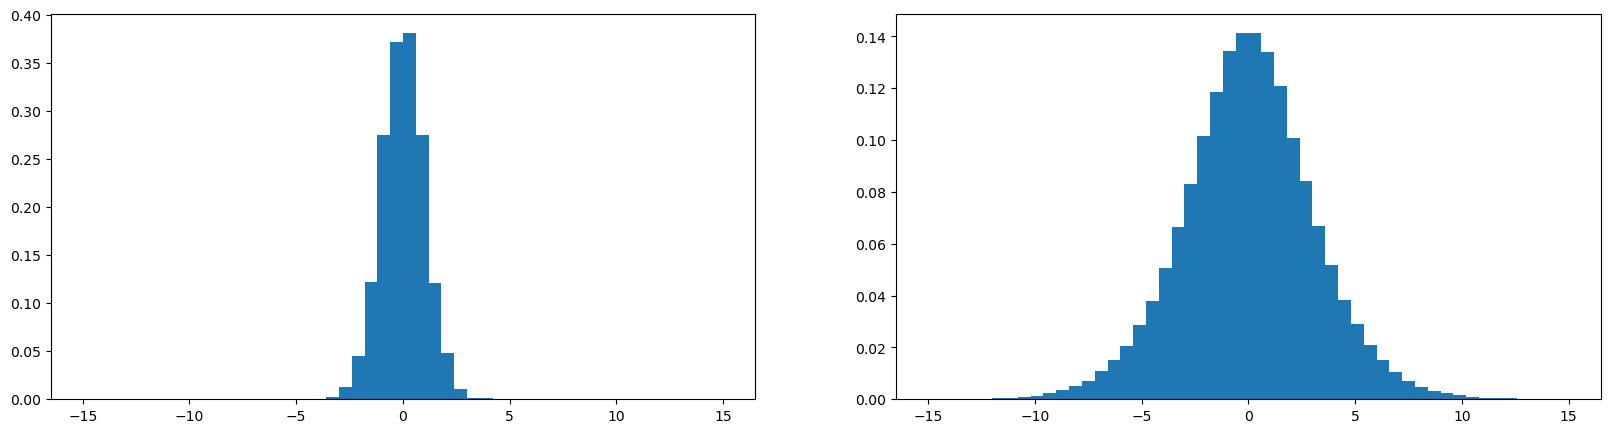

In [20]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, range=[-15, 15], density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, range=[-15, 15], density=True);

Matematicamente, se $w = (w_1, \ldots, w_m) \stackrel{\text{iid}}{\sim} N(0, I)$ e $x = (x_1, \ldots, x_m) \sim N(0, I)$, então 
$$
\mathbb{V}[w^Tx] = \mathbb{V}\left[\sum_{i=1}^m w_i x_i\right] = \sum_{i=1}^m \mathbb{V}[w_ix_i]= \sum_{i=1}^m \mathbb{V}[w_i]\mathbb{V}[x_i] = m.
$$
Ou seja, a amostra da esquerda tem desvio-padrão 1, mas a da direita já tem desvio-padrão $\sqrt{m} = \sqrt{10}\approx 3.16$. Precisamos escalonar os parâmetros em `w` por $1/\sqrt{m}$ para o resultado do produto reter desvio-padrão igual a 1.

In [21]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / (10**0.5)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

tensor(0.0089) tensor(1.0091)
tensor(0.0046) tensor(0.9888)


Se o passo seguinte à transformação linear é uma função de ativação, em geral queremos levá-la em conta na hora de inicializar os parâmetros. Por exemplo, uma função de ativação relu costuma descartar metade das amostras:

<img src="https://machinelearningmastery.com/wp-content/uploads/2018/10/Line-Plot-of-Rectified-Linear-Activation-for-Negative-and-Positive-Inputs.png" width="50%">

Por isso, se o passo seguinte à transformação linear é uma ativação relu, nós consideramos a correção como sendo $\sqrt{2/m}$, já que a variância é reduzida a aproximadamente metade. Esse escalonamento em função da ativação posterior é chamado de "ganho". Essa página agrega vários valores para diferentes ativações: https://pytorch.org/docs/stable/nn.init.html.

No caso de tanh, há um ganho de 5/3, que corrige o fato de que a ativação tanh comprime valores em $\mathbb{R}$ para valores em $[-1, 1]$ então, assim como a relu, o ganho age para compensar essa redução de variância. Isso vem de $\mathbb{V}[\tanh(Z)] = \int_{-\infty}^{\infty} (\tanh x)^2 \cdot \frac{e^{-\frac{x^2}{2}}}{\sqrt{2\pi}} \approx 0.39$, então o desvio-padrão é $\sqrt{0.39} \approx 0.63 \approx 3/5$.

In [22]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / (10**0.5)
y = torch.tanh(x @ w) * (5/3)
print(x.mean(), x.std())
print(y.mean(), y.std())

tensor(-0.0077) tensor(0.9968)
tensor(-0.0005) tensor(1.0224)


Ou seja, uma escolha mais rigorosa de inicialização do que a que encontramos acima para `W1` seria:

In [23]:
vocab_size = len(itos)  # número de caracteres: 27 (a, b, c..., z, .)
n_embd = 10  # dimensionalidade do vetor de embedding
n_hidden = 100  # número de neurônios na camada escondida

torch.manual_seed(0)
g = torch.Generator().manual_seed(0)
C = torch.randn((vocab_size, n_embd),                  generator=g)
# ---------------------------------------------------------------------------------------------------------
W1 = torch.randn((n_embd * block_size, n_hidden),      generator=g) * (5/3)/( (n_embd * block_size) ** 0.5)
# ---------------------------------------------------------------------------------------------------------
b1 = torch.randn(n_hidden,                             generator=g) * 0
W2 = torch.randn((n_hidden, vocab_size),               generator=g) * 0.01
b2 = torch.randn(vocab_size,                           generator=g) * 0
parameters = [C, W1, b1, W2, b2]

Isto é, ao invés do 0.2 que usamos antes, a literatura sugere $\frac{5}{3} \cdot \frac{1}{\sqrt{30}} \approx 0.3$. Perto o suficiente!

## 3.3 Solução geral: batchnorm

Para os dois problemas acima, nós os resolvemos considerando cuidadosamente como iniciar os parâmetros. Vimos que, se os parâmetros não estiverem bem inicializados, é possível que o problema se agrave com o passar das camadas, o que torna essa questão particularmente perniciosa para arquiteturas mais profundas, tais como quereremos considerar daqui a pouco. Mesmo assim, a nossa solução é relativamente delicada e manual. Seria melhor ter uma maneira de garantir que os gradientes não explodirão sem precisar fazer muitos experimentos.

Esse problema é uma área ativa de pesquisa. Várias das melhores soluções que temos hoje foram desenvolvidas recentemente:
- conexões residuais
- otimizadores melhores
- camadas de normalização (incluindo batchnorm)

Vamos olhar para batchnorm, uma das maneiras mais utilizadas para se estabilizar o treino de redes neurais. Veremos as outras ideias posteriormente.

Ideia: normalizar os batches antes de eles passarem pela ativação. Isto é, subtraímos a média e dividimos pelo desvio-padrão; ambas as operações são diferenciáveis! Isto é, transformamos um batch $\{x_1, \ldots, x_B\}$, em $\{\tilde{x}_1, \ldots, \tilde{x}_B\}$ via

- média do batch: $\mu_B = \frac{1}{B}\sum_{b=1}^B x_b$
- variância do batch: $\sigma^2_B = \frac{1}{B}\sum_{b=1}^B (x_b - \mu_B)^2$
- normalização: $\tilde{x}_b = \frac{x_b - \mu_B}{\sqrt{\sigma^2_B + \varepsilon}}$
- ajuste de escala: $\hat{x}_b = \gamma \cdot \tilde{x}_b + \beta \equiv \text{BN}_{\gamma, \beta}(x_b)$

Acima, os parâmetros $\gamma$ e $\beta$ são aprendidos e comuns a todos os batches e servem para dar mais liberdade ao ajuste de normalização; $\varepsilon$ é um número pequeno que evita problemas quando $\sigma^2_B$ é muito pequeno (vamos ignorá-lo no nosso caso). Para que ajustar a escala se acabamos de normalizar a amostra? Em alguns casos isso pode ser vantajoso para a ativação que vem em seguida, e a normalização permite que todos os batches estejam numa mesma escala a ser alterada; sem a normalização, cada batch teria uma média que depende de uma interação complicada das camadas anteriores. A normalização reduz o efeito do que veio antes, e permite que a escolha de escala seja feita para todos os batches.

Note que agora o parâmetro de viés da primeira camada, `b1`, passa a ser desnecessário, porque a camada de batchnorm já tem expressividade para adicionar um viés a todas as entradas. 

In [24]:
vocab_size = len(itos)  # número de caracteres: 27 (a, b, c..., z, .)
n_embd = 10  # dimensionalidade do vetor de embedding
n_hidden = 100  # número de neurônios na camada escondida

torch.manual_seed(0)
g = torch.Generator().manual_seed(0)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# Novos parâmetros de batchnorm
bngain = torch.ones((1, n_hidden))  # gama
bnbias = torch.zeros((1, n_hidden))  # beta

parameters = [C, W1, W2, b2, bngain, bnbias]
print(f"Número de parâmetros: {sum(p.nelement() for p in parameters)}")
for p in parameters:
    p.requires_grad = True

# mesma otimização de antes
max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
    # forward pass
    emb = C[Xb] # embedding
    embcat = emb.view(emb.shape[0], -1)
    # Linear layer
    hpreact = embcat @ W1 #+ b1 # pré-ativação da camada escondida
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    # -------------------------------------------------------------
    # Não-linearidade
    h = torch.tanh(hpreact) # camada escondida
    logits = h @ W2 + b2 # camada de output
    loss = F.cross_entropy(logits, Yb) # função perda

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 80000 else 0.01 # decaimento da taxa de aprendizado
    for p in parameters:
        p.data += -lr * p.grad

    # estatísticas de treino
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

Número de parâmetros: 7862
      0/ 100000: 3.7479
  10000/ 100000: 1.5103
  20000/ 100000: 2.2173
  30000/ 100000: 1.9544
  40000/ 100000: 1.7264
  50000/ 100000: 2.2196
  60000/ 100000: 1.8895
  70000/ 100000: 2.2264
  80000/ 100000: 1.4865
  90000/ 100000: 2.1099


In [25]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    # Novidade: batchnorm --------------
    hpreact = embcat @ W1 # + b1
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    # ----------------------------------
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.8588827848434448
val 1.8280446529388428


No caso acima, houve uma leve piora em relação ao caso anterior, mas agora temos mais parâmetros. Além disso, já gastamos muito tempo escolhendo a melhor maneira de inicializar os parâmetros. Mas numa rede muitas camadas, batchnorm passa a ser essencial porque controla e, num certo sentido, isola o efeito de escala dos gradientes na medida em que eles fluem no grafo, evitando explosões ou implosões.

Mas, repare que há um preço a ser pago. A escolha dos batches foi feita por eficiência computacional, mas agora, como normalizamos o batch, há uma influência de todos os elementos escolhidos aleatoriamente para estarem num batch na determinação da escala de média e variância! Se por um lado isso parece um acoplamento artificial, por outro parece conferir algum grau de regularização à rede, na medida em que ela precisa ser robusta a ruídos que aparecem pela natureza aleatória dos batches (em certo sentido, isso pode ser visto como um esquema de data augmentation).

Um preço maior é o fato de que não mais conseguimos fazer a previsão para um ponto só! Como normalizamos o batch, se ele for composto de um elemento só nós ele será subtraído pela média. A solução mais frequente é encontrar a média e o desvio-padrão no conjunto de treino todo, e usá-lo na hora da validação e teste também. Para não precisar fazer isso como um passo adicional, ao final do treino, várias pessoas usam um contador ao longo do processo de treino que calcula a média e variância. Note que não são parâmetros aprendidos.

In [26]:
vocab_size = len(itos)  # número de caracteres: 27 (a, b, c..., z, .)
n_embd = 10  # dimensionalidade do vetor de embedding
n_hidden = 100  # número de neurônios na camada escondida

torch.manual_seed(0)
g = torch.Generator().manual_seed(0)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# Novos parâmetros de batchnorm
bngain = torch.ones((1, n_hidden))  # gama
bnbias = torch.zeros((1, n_hidden))  # beta
# -------------------------------------------------------------
bnmean_running = torch.zeros((1, n_hidden)) # valor corrente para média
bnstd_running = torch.ones((1, n_hidden))  # valor corrente para desvio-padrão
# -------------------------------------------------------------

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

# same optimization as last time
max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    # BatchNorm layer
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    # -------------------------------------------------------------
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 80000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

7862
      0/ 100000: 3.7479
  10000/ 100000: 1.5103
  20000/ 100000: 2.2173
  30000/ 100000: 1.9544
  40000/ 100000: 1.7264
  50000/ 100000: 2.2196
  60000/ 100000: 1.8895
  70000/ 100000: 2.2264
  80000/ 100000: 1.4865
  90000/ 100000: 2.1099


(Acima, usamos 0.999 e 0.001 para que o cálculo da média e do desvio-padrão se estabilize, de modo que (i) mais batches (portanto mais amostras) tenham sido considerados no cálculo dessas estatísticas, e (ii) as últimas épocas recebam mais peso, dado que nas primeiras a camada linear ainda estará sendo aprendida. É possível usar outros valores para batches de tamanhos muito maiores ou menores, ou cuja média ou variância mudem muito de acordo com o batch.)

O valor dos parâmetros que encontramos de maneira corrente é bem perto do que obteríamos calculando a média e desvio-padrão no conjunto de treino todo:

In [27]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

print(bnmean_running[0][0:10])
print(bnmean[0][0:10])

tensor([-1.9584, -0.8743,  1.7688,  1.2136, -0.6219, -0.3591, -0.3900, -0.6907,
        -0.7810, -0.2417])
tensor([-1.9439, -0.8678,  1.7620,  1.2045, -0.6238, -0.3368, -0.4002, -0.7040,
        -0.7794, -0.2220])


Com isso, podemos calcular o valor das perdas sem depender do número de instâncias na validação ou teste:

In [28]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
#   hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    # ----------------------------------
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    # ----------------------------------
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.8588100671768188
val 1.8274856805801392


Ou seja, usando batchnorm nós conseguimos nos preocupar menos com as questões de inicialização e gradientes explosivos/dissipantes, e começar a criar redes com mais camadas sem se preocupar com a estabilidade do treino.

In [29]:
torch.manual_seed(0)
g = torch.Generator().manual_seed(0)
out = []
context = [0] * block_size
for i in range(200):
#     emb = C[torch.tensor([context])]
#     h = torch.tanh(emb.view(1, -1) @ W1 + b1)
#     logits = h @ W2 + b2
    emb = C[torch.tensor([context])]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
#   hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    # ----------------------------------
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    # ----------------------------------
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    
print(''.join(itos[i] for i in out))

cala para lega fuia. tiver que encoi. a fos dizeram, hantoguémela dísrar rê-la o dento cheve de filha, só,-nha famaror, não o pode dibúlas que mes de tram não, do mos destava podo maria dever cons jom


Claramente ainda há espaço para melhoras. A direção natural é deixar a rede mais complexa.